In [ ]:
import numpy as np
from scipy.optimize import minimize
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
def optimize_radii(centers,radii):
    """
    Construct an optimized arrangement of 32 circles in a unit square
    using mathematical principles and optimization techniques.

    Returns:
        Tuple of (centers, radii, sum_of_radii)
        centers: np.array of shape (32, 2) with (x, y) coordinates
        radii: np.array of shape (32) with radius of each circle
        sum_of_radii: Sum of all radii
    """
    n = 32
    assert len(centers) == n
    assert len(radii) == n
    #seed = 42
    #random.seed(seed)
    #np.random.seed(seed)
    # Objective function: Negative sum of radii (to maximize)
    def objective(x):
        centers = x[: 2 * n].reshape(n, 2)
        radii = x[2 * n :]
        return -np.sum(radii)

    # Constraint: No overlaps and circles stay within the unit square
    def constraint(x):
        centers = x[: 2 * n].reshape(n, 2)
        radii = x[2 * n :]
        # Overlap constraint
        overlap_constraints = []
        for i in range(n):
            for j in range(i + 1, n):
                dist = np.sqrt(np.sum((centers[i] - centers[j]) ** 2))
                overlap_constraints.append(dist - (radii[i] + radii[j]))

        # Boundary constraints
        boundary_constraints = []
        for i in range(n):
            boundary_constraints.append(centers[i, 0] - radii[i])  # x >= radius
            boundary_constraints.append(1 - centers[i, 0] - radii[i])  # x <= 1 - radius
            boundary_constraints.append(centers[i, 1] - radii[i])  # y >= radius
            boundary_constraints.append(1 - centers[i, 1] - radii[i])  # y <= 1 - radius

        return np.array(overlap_constraints + boundary_constraints)

    # Initial guess vector
    x0 = np.concatenate([centers.flatten(), radii])

    # Bounds: Circles stay within the unit square and radii are positive
    bounds = [(0, 1)] * (2 * n) + [(0.03, 0.2)] * n  # radii are positive, up to 0.2

    # Constraints dictionary
    constraints = {"type": "ineq", "fun": constraint}

    # Optimization using SLSQP
    result = minimize(
        objective,
        x0,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"maxiter": 1000, "ftol": 1e-8},
    )

    # Extract optimized centers and radii
    optimized_centers = result.x[: 2 * n].reshape(n, 2)
    optimized_radii = result.x[2 * n :]

    # Ensure radii are not negative (numerical stability)
    optimized_radii = np.maximum(optimized_radii, 0.001)

    # Calculate the sum of radii
    sum_radii = np.sum(optimized_radii)
    return optimized_centers, optimized_radii, sum_radii

def visualize(centers, radii):
    """
    Visualize the circle packing

    Args:
        centers: np.array of shape (n, 2) with (x, y) coordinates
        radii: np.array of shape (n) with radius of each circle
    """
    

    fig, ax = plt.subplots(figsize=(4, 4))

    # Draw unit square
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect("equal")
    ax.grid(True)

    # Draw circles
    for i, (center, radius) in enumerate(zip(centers, radii)):
        circle = Circle(center, radius, alpha=0.5)
        ax.add_patch(circle)
        ax.text(center[0], center[1], str(i), ha="center", va="center")

    plt.title(f"Circle Packing (n={len(centers)}, sum={sum(radii):.6f})")
    plt.show()

import numpy as np

def has_overlap(centers, radii, tolerance=1e-8):
    """
    检查圆之间是否有重叠，并返回累计重叠误差
    overlap_error > 0 表示有重叠，且值越大重叠越严重
    """
    n = len(centers)
    total_error = 0.0
    has_violation = False

    for i in range(n):
        for j in range(i + 1, n):
            dist = np.linalg.norm(centers[i] - centers[j])
            allowed_dist = radii[i] + radii[j] 
            if dist < allowed_dist:  # 有重叠
                has_violation = True
                # 累计误差 = 相交的深度
                total_error += (allowed_dist - dist)

    return has_violation, total_error


def has_out_of_bounds(centers, radii, eps=1e-8):
    """
    检查圆是否超出边界（单位正方形），并返回累计超出误差
    out_error > 0 表示有超出，且值越大超出越严重
    """
    total_error = 0.0
    has_violation = False

    for (x, y), r in zip(centers, radii):
        left_overflow   = max(0.0, -(x - r) )   # 左边界
        right_overflow  = max(0.0, (x + r) - 1 ) # 右边界
        bottom_overflow = max(0.0, -(y - r) )    # 下边界
        top_overflow    = max(0.0, (y + r) - 1 ) # 上边界

        overflow_sum = left_overflow + right_overflow + bottom_overflow + top_overflow
        if overflow_sum > 0:
            has_violation = True
            total_error += overflow_sum

    return has_violation, total_error

def cal_error(centers,radii):
    total_error = 0
    has_violation, error = has_out_of_bounds(centers,radii)
    total_error += error
    has_violation, error = has_overlap(centers,radii)
    total_error += error
    return total_error


In [ ]:
import pickle
import json
with open('/home/hp/src/mollm_results/zgca,gemini-2.5-flash-nothinking/mols/radii_circle_packing_32_42.pkl','rb') as f:
    results = pickle.load(f)
all_mol = [i[0] for i in results['all_mols']]
all_mol = sorted(all_mol,key=lambda x: x.total,reverse=True)
top10 = all_mol[:10]
for i in range(100):
    print(all_mol[i].total)
    if all_mol[i].total<2.93957:
        second = all_mol[i]
        break

2.9395727729246106
2.9395727717123235
2.9395727713074984
2.9395727712084003
2.9395727712070827
2.939572771206773
2.939572771206559
2.9395727712065236
2.9395727712064437
2.939572771206346
2.939572771206154
2.939572771206109
2.9395727712060773
2.939572771206061
2.9395727712060093
2.9395727712060093
2.9395727712059996
2.9395727712059143
2.9395727712054187
2.939572771205367
2.939572771205176
2.9395727712048707
2.9395727712044257
2.9395727712028297
2.9395727712006456
2.9395727712004507
2.9395727712004427
2.9395727712003312
2.939572771200215
2.9395727712002078
2.9395727712001065
2.939572771200093
2.9395727711999786
2.9395727711999737
2.9395727711999724
2.9395727711999724
2.9395727711999715
2.9395727711999706
2.9395727711998614
2.9395727711998605
2.939572771199857
2.939572771199856
2.939572771199742
2.9395727711997335
2.9395727711996895
2.9395727711996384
2.939572771199501
2.9395727711995
2.9395727711993853
2.9395727711967936
2.939572771196752
2.93957277119654
2.9395727711957162
2.93957277119

In [18]:
visualize_from_item(second)

total error 1.5414752807529908e-13


total error 1.3378187446733136e-14


total error 2.0816681711721685e-15


total error 5.245803791353865e-15


total error 0.0


total error 2.850844560420285e-13


total error 0.0


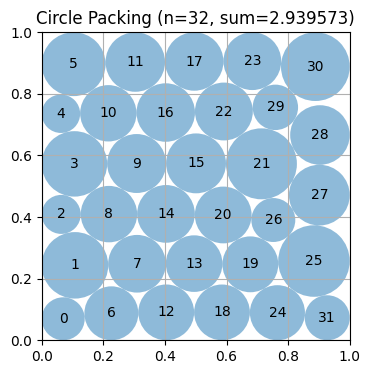

total error 2.55351295663786e-14


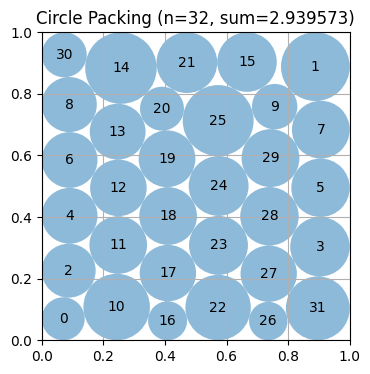

total error 2.780761731990822e-13


total error 1.7458257062230587e-14


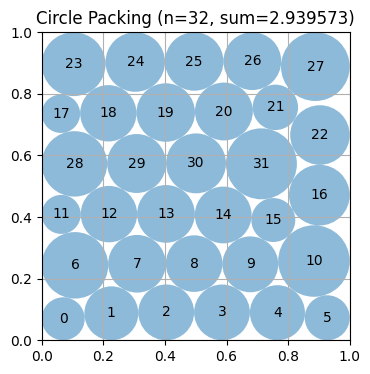

In [21]:
import numpy as np
scope = {}
def visualize_from_item(item):
    exec(item.value, {"np": np}, scope)
    centers = scope["centers"]
    radii = scope["radii"]
    centers,radii,sum_radii = optimize_radii(centers,radii)
    print('total error',cal_error(centers,radii))
    visualize(centers,radii)
for i in top10:
    visualize_from_item(i)